## 序列数据加载

In [86]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [90]:


# 1. 加载数据
file_path = 'data/summerOly_athletes_total_with_types.csv'
data = pd.read_csv(file_path)

# 2. 数据预处理

# 获取独特的运动项目、年份和代表队
sports = sorted(data['Type'].unique())  # 运动项目 S
years = sorted(data['Year'].unique())   # 奥运会年份 T
nocs = sorted(data['NOC'].unique())     # 国家代表队 N

# 构建映射表
sport_to_idx = {sport: i for i, sport in enumerate(sports)}
year_to_idx = {year: i for i, year in enumerate(years)}
noc_to_idx = {noc: i for i, noc in enumerate(nocs)}
print(sport_to_idx)
print(noc_to_idx)

# 初始化结果张量
S, T, N = len(sports), len(years), len(nocs)
# N = 234
result_tensor = np.zeros((S, T, N), dtype=int)

# 过滤掉没有奖牌的数据
data = data[data['Medal'] != 'No medal']
# 去重
data = data.drop_duplicates(subset=['Event', 'Year', 'Medal', 'NOC', 'Sport'])
# 保存去重后的数据
data.to_csv('data/summerOly_athletes_no_dup.csv', index=False)
                                      
# 3. 构建张量
for _, row in data.iterrows():
    sport_idx = sport_to_idx[row['Type']]
    year_idx = year_to_idx[row['Year']]
    noc_idx = noc_to_idx[row['NOC']]
    result_tensor[sport_idx, year_idx, noc_idx] += 1  # 标记该国家在该年该运动有奖牌

# 4. 保存结果
output_path = 'data/olympic_medals_with_type.npy'
np.save(output_path, result_tensor)
print(f"结果张量已保存到 {output_path}")
print(f"张量形状: {result_tensor.shape}")  # 输出 S*T*N 的张量形状


{'Artistic Sports': 0, 'Athletics': 1, 'Combat Sports': 2, 'Cycling Sports': 3, 'Endurance Sports': 4, 'Equestrian': 5, 'Extreme Sports': 6, 'Gymnastics': 7, 'Other Traditional Sports': 8, 'Racket Sports': 9, 'Small Ball Sports': 10, 'Team Ball Sports': 11, 'Water Sports': 12, 'Weapon Sports': 13, 'Winter Sports': 14}
{'AFG': 0, 'AHO': 1, 'AIN': 2, 'ALB': 3, 'ALG': 4, 'AND': 5, 'ANG': 6, 'ANT': 7, 'ANZ': 8, 'ARG': 9, 'ARM': 10, 'ARU': 11, 'ASA': 12, 'AUS': 13, 'AUT': 14, 'AZE': 15, 'BAH': 16, 'BAN': 17, 'BAR': 18, 'BDI': 19, 'BEL': 20, 'BEN': 21, 'BER': 22, 'BHU': 23, 'BIH': 24, 'BIZ': 25, 'BLR': 26, 'BOH': 27, 'BOL': 28, 'BOT': 29, 'BRA': 30, 'BRN': 31, 'BRU': 32, 'BUL': 33, 'BUR': 34, 'CAF': 35, 'CAM': 36, 'CAN': 37, 'CAY': 38, 'CGO': 39, 'CHA': 40, 'CHI': 41, 'CHN': 42, 'CIV': 43, 'CMR': 44, 'COD': 45, 'COK': 46, 'COL': 47, 'COM': 48, 'CPV': 49, 'CRC': 50, 'CRO': 51, 'CRT': 52, 'CUB': 53, 'CYP': 54, 'CZE': 55, 'DEN': 56, 'DJI': 57, 'DMA': 58, 'DOM': 59, 'ECU': 60, 'EGY': 61, 'EOR': 

In [91]:
total = result_tensor[:,year_to_idx[2024],noc_to_idx['CHN']].sum()
print(total)

91


## 平滑操作

In [92]:


def smooth_distribution_with_decrease(A, B, smooth_factor=0.1):
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)
    # 确保 A 和 B 的长度相等
    assert A.shape == B.shape, f"A({A.shape}) and B({B.shape}) must have the same shape."
    # 标准化 B，避免 B 全零的情况
    if B.sum() > 0:
        B_norm = B / B.sum()
    else:
        B_norm = np.zeros_like(B)
    
    # 构造平滑因子
    S = B_norm * smooth_factor
    # 初始化平滑后的 A
    A_smoothed = np.zeros_like(A)
    
    # 对 A 的每一项进行更新
    for i in range(len(A)):
        if A[i] == 0:
            # A[i] 为 0 的情况下，平滑值来源于 S[i]
            A_smoothed[i] = S[i]
        else:
            # A[i] 为非零时，值减少，且减少量不能超过 S[i]
            A_smoothed[i] = A[i] - min(A[i], S[i])
    
    # 保证 B[i] 为 0 时 A_smoothed 也为 0
    A_smoothed[B == 0] = 0
    
    return A_smoothed

sport_to_idx_inv = {v: k for k, v in sport_to_idx.items()}
for idx in range(S):
    # 加载某一项运动对应的数据作为时间序列数据用于训练
    medal_dist = torch.tensor(np.load('data/olympic_medals_with_type.npy')[idx], dtype=torch.float32).numpy()

    # 加载对应的运动员数量-国家分布作为平滑参数
    sport = sport_to_idx_inv[idx]
    file_path = f'data/athletes_count/{sport}.csv'
    athletes_count = pd.read_csv(file_path)
    # 列索引中年份并不是顺序的，需要重新排序
    years = sorted(athletes_count.columns)
    athletes_count = athletes_count[years]
    # 将数据转换为 NumPy 数组
    athletes_per_noc = athletes_count.values
    # 每一行的最后一项是NOC并转置，使每一行表示每一年的运动员数量-国家分布
    athletes_per_noc = athletes_per_noc[:, :-1].T


    # 对每个年份的分布进行平滑处理
    for i in range(T):
        medal_dist[i] = smooth_distribution_with_decrease(medal_dist[i], athletes_per_noc[i])
    # 保存平滑后的数据
    np.save(f'data/medals_dist_smoothed/{idx}.npy', medal_dist)


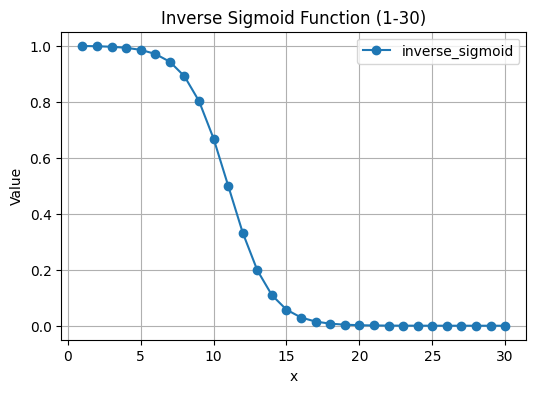

In [ ]:
import torch
import matplotlib.pyplot as plt

def inverse_sigmoid(x, k=-0.7, c=20):
    """
    将 1 到 30 的整数映射到 0 到 1 范围内，并呈现反 sigmoid 函数的单调递减趋势。
    :param x: 输入值 (torch.Tensor)
    :param k: 控制曲线陡峭程度
    :param c: 控制曲线中心点
    :return: 映射到 0 到 1 范围内的值
    """
    return 1 / (1 + torch.exp(k * ((31 - x) - c)))

# 生成 x 在 [1, 30] 整数范围内的取值
x = torch.arange(1, 31, dtype=torch.float32)
# 计算对应的 y
y = inverse_sigmoid(x)

# 绘图
plt.figure(figsize=(6, 4))
plt.plot(x, y, marker='o', label='inverse_sigmoid')
plt.title('Inverse Sigmoid Function (1-30)')
plt.xlabel('x')
plt.ylabel('Value')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()


## 建立模型 （针对某一项运动）

In [108]:
import torch
import torch.nn as nn

# 定义权重优化模型
class WeightOptimizer(nn.Module):
    def __init__(self, T):
        super(WeightOptimizer, self).__init__()
        # 初始化全局权重序列为可训练参数
        self.weights = nn.Parameter(torch.ones(T)*10)  # 长度为 T 的权重序列

    def inverse_sigmoid(self, x, k=-0.7, c=20):
        """
        将1到30的整数映射到0到1范围内，并呈现反sigmoid函数的单调递减趋势。
        :param x: 输入值 (torch.Tensor)
        :param k: 控制曲线陡峭程度
        :param c: 控制曲线中心点
        :return: 映射到0到1范围内的值
        """
        return 1 / (1 + torch.exp(k * ((31 - x) - c)))

    def forward(self, x):
        T, N = x.size()  # 时间序列长度和向量维度
        total_loss = 0  # 损失累计

        for k in range(1, T):  # 从时间步 2 开始预测
            # 定义一个时间距离序列，从k到1
            dist = torch.tensor([i for i in range(k, 0, -1)], dtype=torch.float32, device=x.device)  # (k,)
            # 通过 inverse_sigmoid 将距离映射为一个单调递减的权重序列
            dist_weights = self.inverse_sigmoid(dist)  # (k,)
            # 最终权重为原始权重和距离权重的乘积
            k_weights = dist_weights * self.weights[:k]  # (k,)

            # 根据权重加权计算预测值
            x_pred = torch.sum(k_weights.unsqueeze(1) * x[:k], dim=0) / torch.sum(k_weights)  # (N,)
            # 计算当前时间步的预测损失
            total_loss += torch.norm(x_pred - x[k]) ** 2

        # 返回平均损失
        return total_loss / T


In [109]:
for idx in range(S):  # 3，7

    # 加载平滑后的数据转换
    x = torch.tensor(np.load(f'data/medals_dist_smoothed/{idx}.npy'), dtype=torch.float32)
    # x = torch.tensor(np.load('data/olympic_medals.npy')[idx], dtype=torch.float32)

    T, N = x.size()  # 时间序列长度和向量维度

    # 实例化模型
    model = WeightOptimizer(T)

    # 定义优化器
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练循环
    num_epochs = 10000
    for epoch in range(num_epochs):
        optimizer.zero_grad()  # 清除梯度
        loss = model(x)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重参数
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

    # 查看学习到的权重
    weights = model.weights
    weights = weights.detach().numpy()
    # 保存学习到的权重
    np.save(f'data/weights/{idx}.npy', weights)

    print(f"Learned weights for {idx}-th sport:", weights)


Epoch 100/10000, Loss: 0.3781
Epoch 200/10000, Loss: 0.3774
Epoch 300/10000, Loss: 0.3766
Epoch 400/10000, Loss: 0.3760
Epoch 500/10000, Loss: 0.3753
Epoch 600/10000, Loss: 0.3747
Epoch 700/10000, Loss: 0.3740
Epoch 800/10000, Loss: 0.3734
Epoch 900/10000, Loss: 0.3729
Epoch 1000/10000, Loss: 0.3723
Epoch 1100/10000, Loss: 0.3718
Epoch 1200/10000, Loss: 0.3713
Epoch 1300/10000, Loss: 0.3708
Epoch 1400/10000, Loss: 0.3703
Epoch 1500/10000, Loss: 0.3698
Epoch 1600/10000, Loss: 0.3693
Epoch 1700/10000, Loss: 0.3689
Epoch 1800/10000, Loss: 0.3685
Epoch 1900/10000, Loss: 0.3680
Epoch 2000/10000, Loss: 0.3676
Epoch 2100/10000, Loss: 0.3672
Epoch 2200/10000, Loss: 0.3669
Epoch 2300/10000, Loss: 0.3665
Epoch 2400/10000, Loss: 0.3661
Epoch 2500/10000, Loss: 0.3658
Epoch 2600/10000, Loss: 0.3654
Epoch 2700/10000, Loss: 0.3651
Epoch 2800/10000, Loss: 0.3648
Epoch 2900/10000, Loss: 0.3644
Epoch 3000/10000, Loss: 0.3641
Epoch 3100/10000, Loss: 0.3638
Epoch 3200/10000, Loss: 0.3635
Epoch 3300/10000,

In [110]:
# 测试模型，使用2024以前的数据预测2024的国家奖牌总数（即所有运动的奖牌分布之和）
pred_medals = np.zeros(N)
target = 31 # 2024年奖牌总数

def inverse_sigmoid(x, k=-0.7, c=20):
    """
    将1到30的整数映射到0到1范围内，并呈现反sigmoid函数的单调递减趋势。
    :param x: 输入值 (torch.Tensor)
    :param k: 控制曲线陡峭程度
    :param c: 控制曲线中心点
    :return: 映射到0到1范围内的值
    """
    return 1 / (1 + torch.exp(k * ((31 - x) - c)))

for idx in range(S):
    # 加载平滑后的数据转换
    x = torch.tensor(np.load(f'data/medals_dist_smoothed/{idx}.npy'), dtype=torch.float32)
    # 转换为NumPy数组
    x = x.detach().numpy()

    # 加载学习到的权重
    weights = np.load(f'data/weights/{idx}.npy')

    # 乘以距离权重
    dist = torch.tensor([i for i in range(target, 0, -1)], dtype=torch.float32)  # (k,)
    # 通过 inverse_sigmoid 将距离映射为一个单调递减的权重序列
    dist_weights = inverse_sigmoid(dist).detach().numpy()  # (k,)

    # 最终权重为原始权重和距离权重的乘积
    k_weights = dist_weights * weights[:target]  # (k,)
    k_weights = k_weights / np.sum(k_weights)
    # 计算预测值
    x_pred = np.sum(k_weights.reshape(-1,1) * x[:target], axis=0)

    # 将预测值累加到总预测奖牌数
    pred_medals += x_pred 


# 输出预测结果 
print("Predicted medals distribution for 2024:", pred_medals)
# 输出指定国家的预测奖牌数
idx_to_noc = {v: k for k, v in noc_to_idx.items()}

# 找到预测结果最大的五个国家
max_indices = np.argsort(pred_medals)[-10:]
print("Top 5 countries with predicted medals in 2024:", [idx_to_noc[idx] for idx in max_indices])
print("Predicted medal counts:", pred_medals[max_indices])


Predicted medals distribution for 2024: [ 3.06070316e-01  4.32411150e-02  5.59866582e-01  1.63713409e-01
  1.86730459e+00  1.27199428e-02  3.46688022e-03  5.50370748e-02
  4.97226140e-03  4.25456448e+00  3.58804048e+00  4.91669116e-03
  9.20155800e-03  4.22651624e+01  9.55512980e-01  7.36357296e+00
  1.69686565e+00  3.12943093e-02  1.47908713e-01  2.82146839e-01
  4.19632382e+00  1.34990171e-02  2.99409559e-02  8.73246555e-03
  5.83047433e-03  1.91890827e-02  1.18807089e+01  2.44731749e-03
  8.18121807e-04  3.32521577e-01  1.14485831e+01  8.12697668e-01
  9.08456937e-04  2.84703914e+00  1.47260744e-01  8.39630039e-04
  9.05814129e-06  8.42017721e+00  1.25038735e-03  4.98618891e-03
  5.17660019e-02  4.34822672e-01  6.64657495e+01  5.76942517e-01
  3.52705081e-01  5.03428599e-04  3.06706010e-04  2.23069212e+00
  3.87195044e-03  3.50485342e-04  3.22921383e-01  1.95799027e+00
  1.72680476e-04  4.40974297e+00  2.81231523e-01  2.99057063e+00
  6.59025862e+00  1.61099081e-03  7.53822990e-02  

### 东道主影响系数回归

数据样例：
   Year NOC  Sport  Medals  Host
0  1896  13     10       3     1
1  1896  14     15       5     1
2  1896  56     17       6     1
3  1896  71     17      11     1
4  1896  76     17       9     1

回归结果: 奖牌 = 12.44 + 0.00 * Host
东道主效应系数 (β1): 0.00

修正前后奖牌数据对比：
   Year NOC  Medals  Corrected_Medals  Host
0  1896  13       3               3.0     1
1  1896  14       5               5.0     1
2  1896  56       6               6.0     1
3  1896  71      11              11.0     1
4  1896  76       9               9.0     1


/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29260 (\N{CJK UNIFIED IDEOGRAPH-724C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/SSD_DISK/us

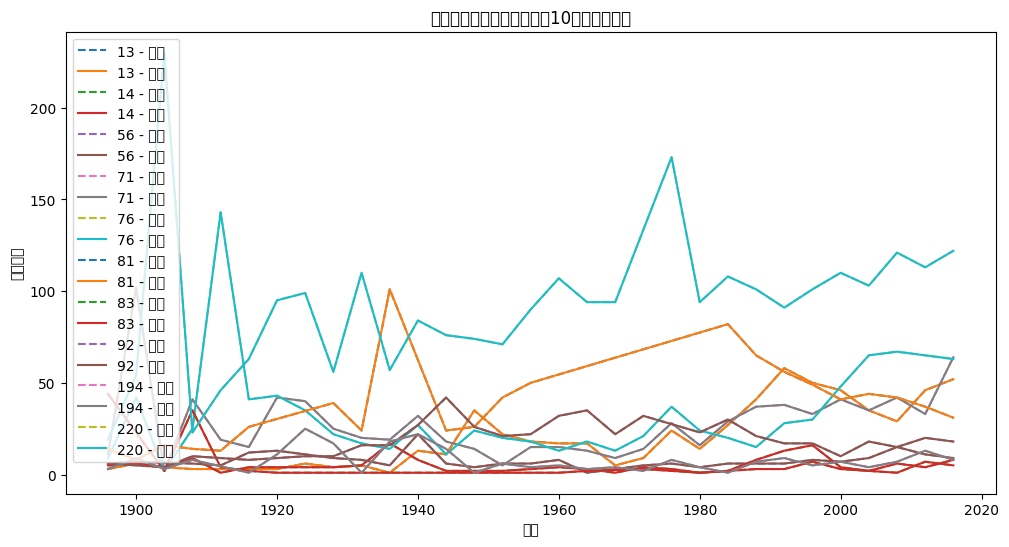

<Figure size 800x600 with 0 Axes>

/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/SSD_DISK/us

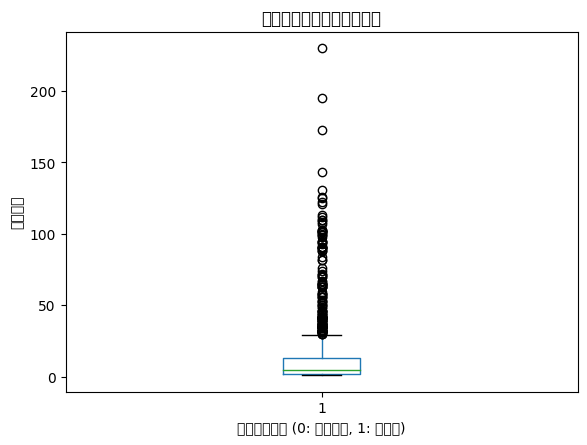


修正后的数据已保存为 `corrected_olympic_data.csv`。


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. 加载数据
# 读取 'data/olympic_medals_with_type.npy'
# 数据结构为 (Sport, Year, NOC)，每一项表示某 NOC 在某年某体育项目中的奖牌数
raw_data = np.load('data/olympic_medals_with_type.npy')  # 三维数组
num_sports, num_years, num_nocs = raw_data.shape

# 转换为 DataFrame，按 Sport、Year、NOC 展开
data = []
for sport in range(num_sports):
    for year in range(num_years):
        for noc in range(num_nocs):
            medals = raw_data[sport, year, noc]
            if medals > 0:  # 仅保留非零奖牌记录
                data.append([sport, 1896 + 4 * year, noc, medals])  # 年份从 1896 开始，每 4 年一届

data = pd.DataFrame(data, columns=['Sport', 'Year', 'NOC', 'Medals'])

# 按 Year 和 NOC 汇总奖牌总数
data = data.groupby(['Year', 'NOC']).sum().reset_index()

# 将 'NOC' 列转换为字符串类型
data["NOC"] = data["NOC"].astype(str)

# 读取 'data/summerOly_hosts_short.csv' 并添加 Host 列
host_data = pd.read_csv('data/summerOly_hosts_short.csv')  # 假设包含列 'Year' 和 'Host'
data = data.merge(host_data, on='Year', how='left')

# 将 'Host' 列转换为布尔值 (1 表示东道主, 0 表示非东道主)
data['Host'] = data['Host'].notnull().astype(int)

# 2. 数据检查
print("数据样例：")
print(data.head())

# 3. 建立线性回归模型
# 自变量: 是否为东道主 (Host)
X = data[["Host"]]
# 因变量: 奖牌数量 (Medals)
y = data["Medals"]

# 创建并训练模型
model = LinearRegression()
model.fit(X, y)

# 获取回归结果
host_effect = model.coef_[0]  # Host 的回归系数 (β1)
intercept = model.intercept_  # 常数项
print(f"\n回归结果: 奖牌 = {intercept:.2f} + {host_effect:.2f} * Host")
print(f"东道主效应系数 (β1): {host_effect:.2f}")

# 4. 修正奖牌数量
# 修正公式: Corrected_Medals = Medals - β1 * Host
data["Corrected_Medals"] = data["Medals"] - host_effect * data["Host"]

# 显示修正前后对比
print("\n修正前后奖牌数据对比：")
print(data[["Year", "NOC", "Medals", "Corrected_Medals", "Host"]].head())

# 5. 可视化分析
# 修正前后奖牌数量的趋势对比（仅展示前10个国家示例）
plt.figure(figsize=(12, 6))
for noc in data["NOC"].unique()[:10]:  # 示例前10个国家
    subset = data[data["NOC"] == noc]
    plt.plot(subset["Year"], subset["Medals"], label=f"{noc} - 原始", linestyle="--")
    plt.plot(subset["Year"], subset["Corrected_Medals"], label=f"{noc} - 修正", linestyle="-")

plt.title("奖牌数量修正前后对比（前10个国家示例）")
plt.xlabel("年份")
plt.ylabel("奖牌数量")
plt.legend()
plt.show()

# 6. 可视化东道主与非东道主奖牌分布
plt.figure(figsize=(8, 6))
data.boxplot(column="Medals", by="Host", grid=False)
plt.title("东道主与非东道主奖牌分布")
plt.suptitle("")  # 移除默认的 matplotlib 子标题
plt.xlabel("是否为东道主 (0: 非东道主, 1: 东道主)")
plt.ylabel("奖牌总数")
plt.show()

# 7. 保存修正后的数据
data.to_csv("corrected_olympic_data.csv", index=False)
print("\n修正后的数据已保存为 `corrected_olympic_data.csv`。")
